# Airfoil experiments
All data is available in the repository

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

large_qmc_points = np.loadtxt('../sobol_6_131072.txt')
all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))


N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]


input_size=6
train_size=128
validation_size=128

epochs = 500000


airfoils_network = [12, 12, 10, 12, 10, 12, 10, 10, 12,1]


# Network sizes

Find the optimal network size


In [ ]:
force_names=['Lift', 'Drag']
train_sizes = [128, 256]
optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}

loss = "mean_squared_error"

selections = {}
selections['Best performing'] = ['mean_train', 'ray_prediction', 'wasserstein_train', 'train']
selections['Emperically optimal'] = ['mean', 'mean_tail', 'prediction', 'wasserstein']



class TrainingFunction(object):
    def __init__(self, *, parameters, samples):
        self.parameters = parameters
        self.samples=samples


    def __call__(self, network_information, output_information):
        showAndSave.prefix='%s_%s_%s_ts_%d_bs_%d' %(title,
            network_information.optimizer.__name__,
            network_information.loss,
            network_information.batch_size,
            network_information.train_size)

        get_network_and_postprocess(self.parameters, self.samples,
                    network_information = network_information,
                    output_information = output_information)


for selection_type in selections.keys():
    display(HTML("<h1>%s</h1>" % selection_type))
    
    for selection in selections[selection_type]:
   
        display(HTML("<h2>%s</h2>" % selection))

   

        training_sizes = [128, 256]

        number_of_widths = 4
        number_of_heights = 4



        for n, force_name in enumerate(force_names):
            display(HTML("<h3>%s</h3>" % force_name))
            parameters = qmc_points
            samples = forces[:, n+1]
            run_function = TrainingFunction(parameters=parameters,
                samples = samples)


            optimizers = {"SGD": keras.optimizers.SGD}

            losses = ["mean_squared_error"]

            optimizer = 'SGD'
            loss = losses[0]
            tables = Tables.make_default()

            network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs,
                                                     network=None, train_size=None,
                                                     validation_size=None,
                                                    loss=loss, tries=5, selection='prediction',
                                                    selection=selection)


            title = '%s %s %s' % (selection_type, selection, force_name)
            short_title = force_name
            output_information = OutputInformation(tables=tables, title=title,
                                                  short_title=title, enable_plotting=False)


            find_best_network_size(network_information = network_information,
                output_information = output_information,
                training_sizes = training_sizes,
                run_function = run_function,
                number_of_depths = number_of_depths,
                number_of_widths = number_of_widths,
                base_title = title)


# One network per variable


Training took 559.9776139259338 seconds


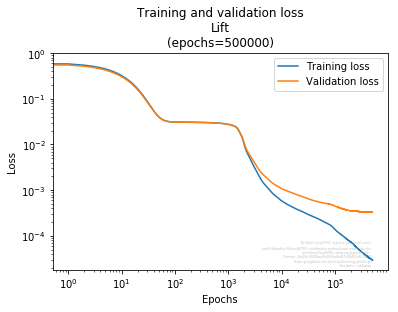


Training took 567.9863646030426 seconds


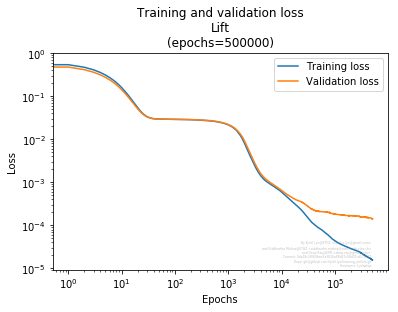


Training took 577.7270920276642 seconds


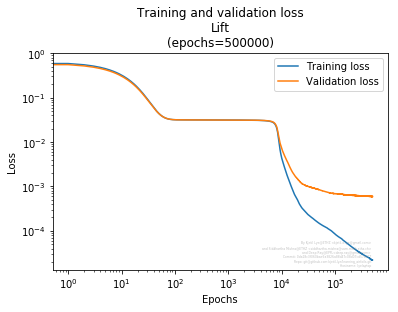


Training took 598.4711446762085 seconds


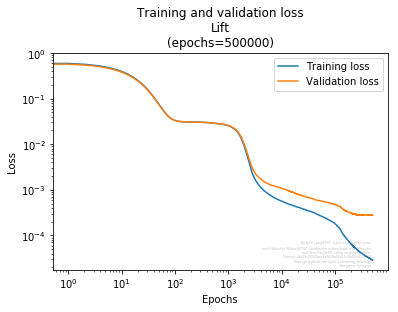


Training took 971.1653711795807 seconds


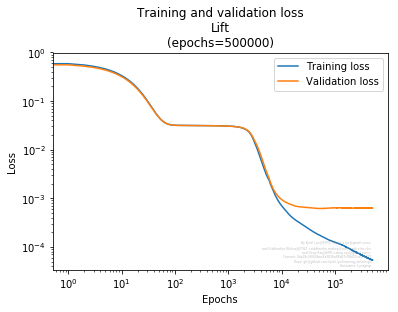


Training took 6594.376106023788 seconds


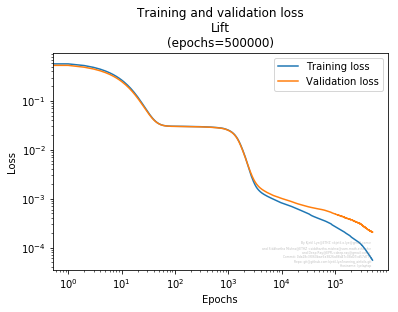


Training took 640.128170967102 seconds


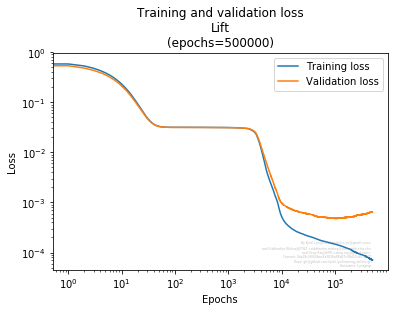


Training took 653.926796913147 seconds


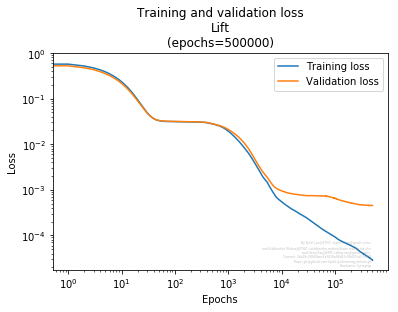


Training took 672.8918840885162 seconds


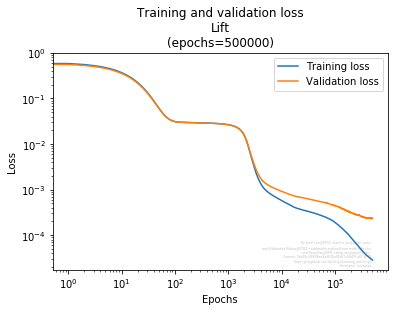


Training took 687.7218811511993 seconds


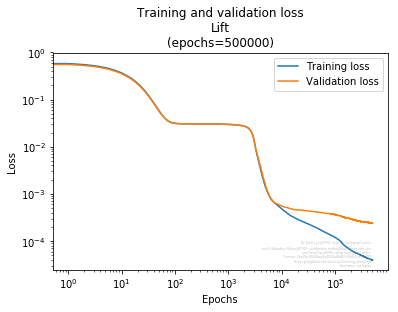

Best network index: 4
Total learning time took: 12654 s


################################################################
#airfoil_mean_SGD_mean_squared_error_Lift_ts_128_bs_128_network#
################################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      12    132
9      1     13
Sum          1149
-----  ----  ----------
################################################################


Training took 700.4961912631989 seconds


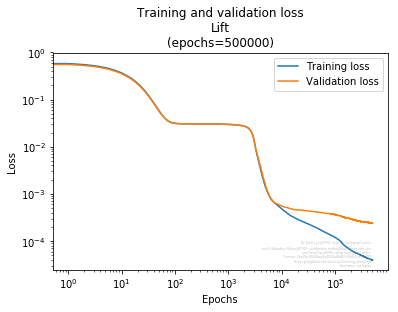

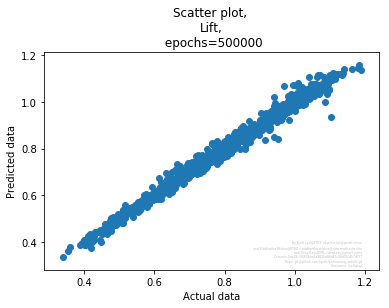

Number of parameters: 1149


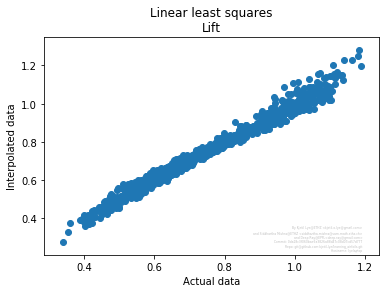

(1001,)
(1001, 6)


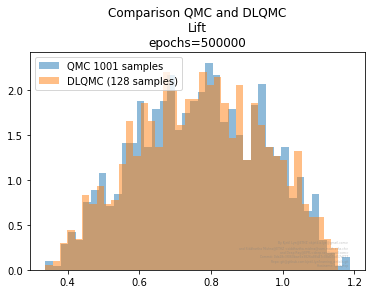

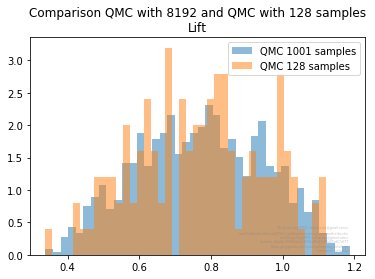

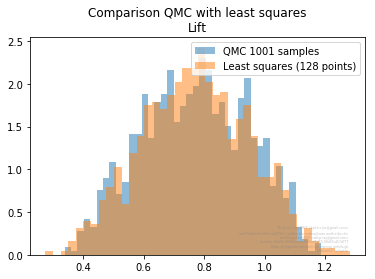

Computing large integration points


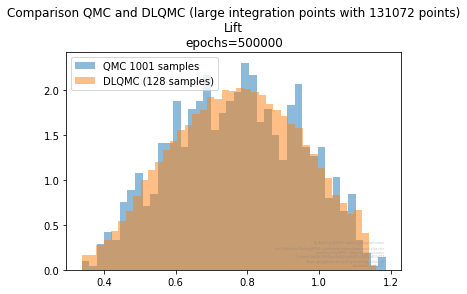

Memory usage: 728208
Memory usage: 728208


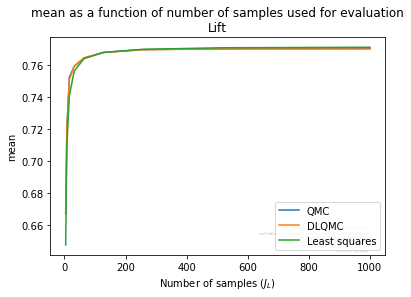

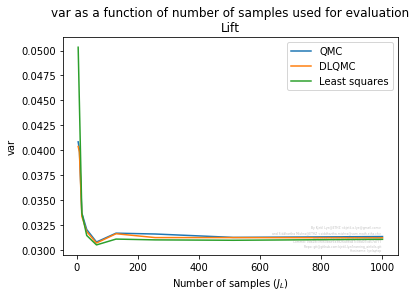

Memory usage: 728208


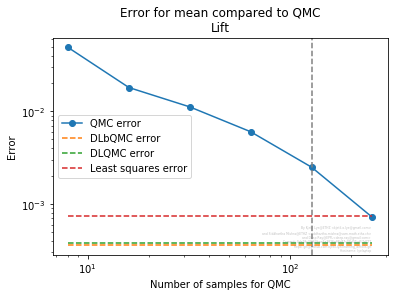

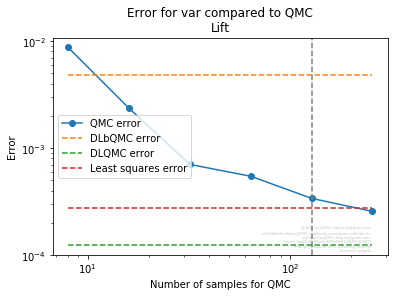

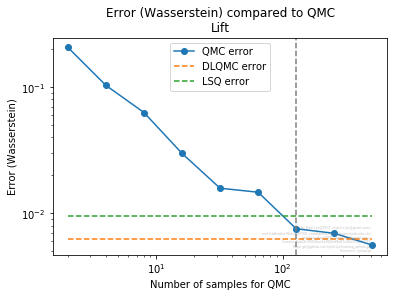

Trying with a large number of QMC samples 131072


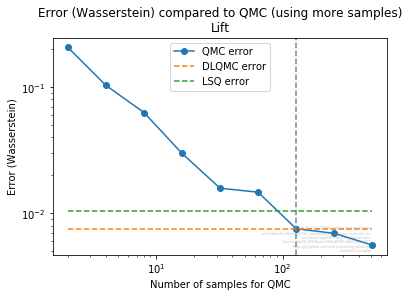


Training took 744.5083029270172 seconds


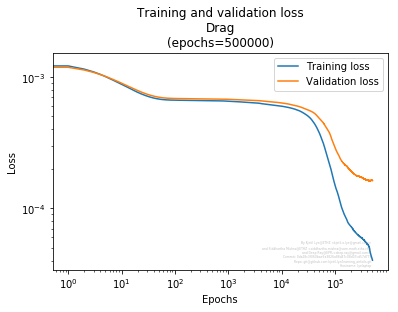


Training took 732.6453335285187 seconds


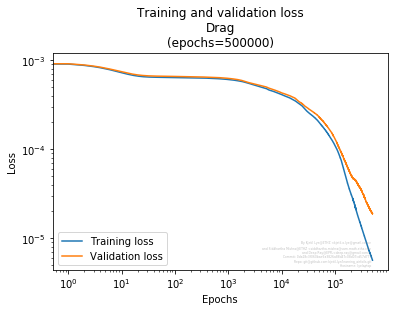


Training took 745.4309983253479 seconds


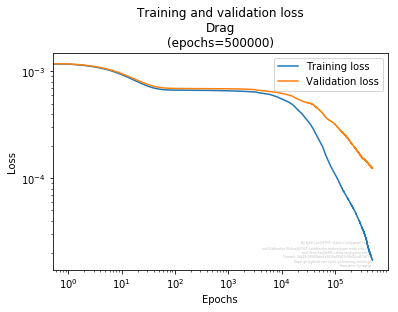


Training took 838.9035754203796 seconds


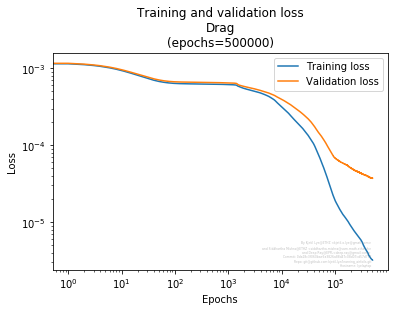


Training took 1536.3058490753174 seconds


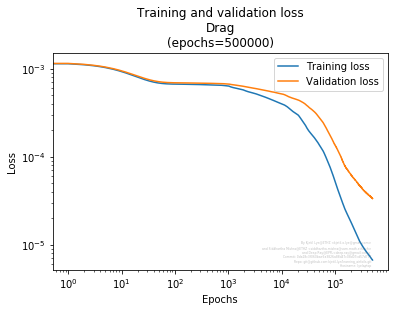


Training took 1193.1374282836914 seconds


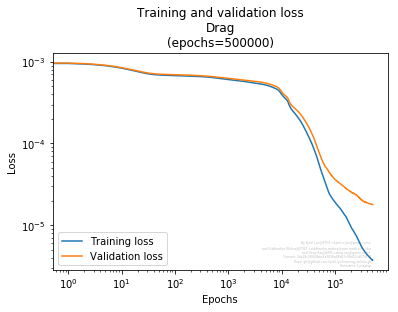


Training took 1535.2065846920013 seconds


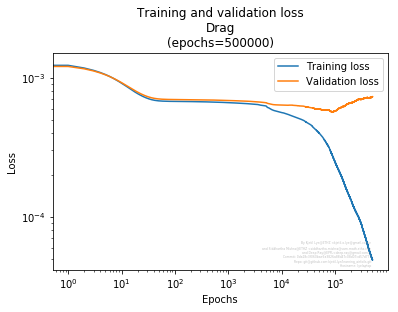


Training took 1437.3738327026367 seconds


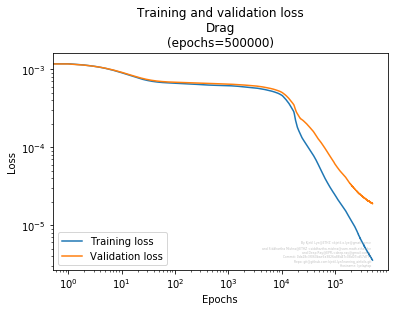


Training took 1515.8778471946716 seconds


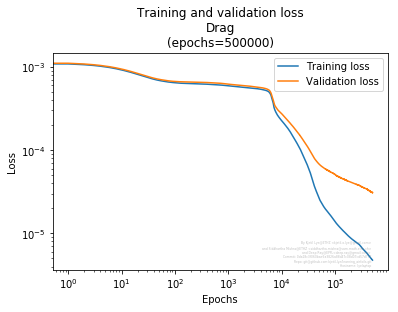


Training took 1195.1290860176086 seconds


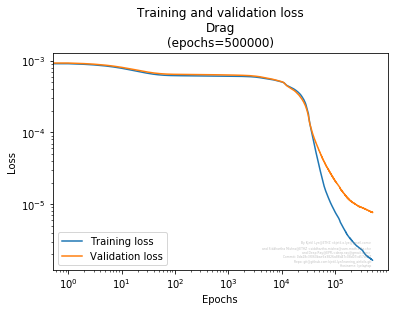

Best network index: 9
Total learning time took: 11699 s


################################################################
#airfoil_mean_SGD_mean_squared_error_Drag_ts_128_bs_128_network#
################################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      12    132
9      1     13
Sum          1149
-----  ----  ----------
################################################################


Training took 1219.490469455719 seconds


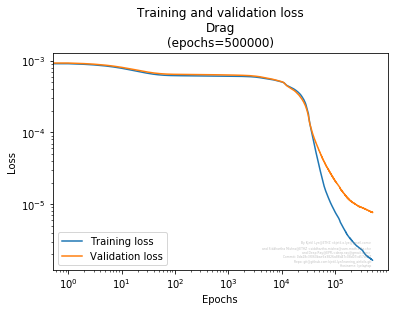

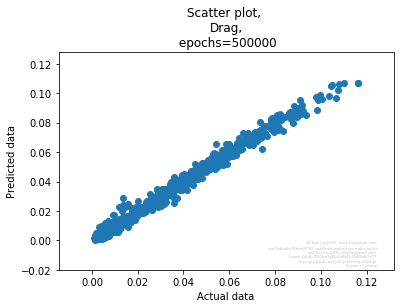

Number of parameters: 1149


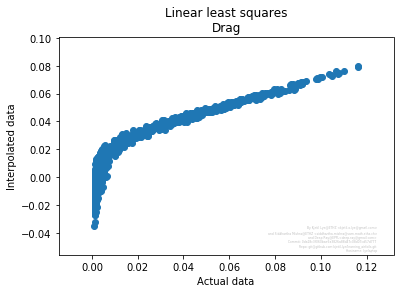

(1001,)
(1001, 6)


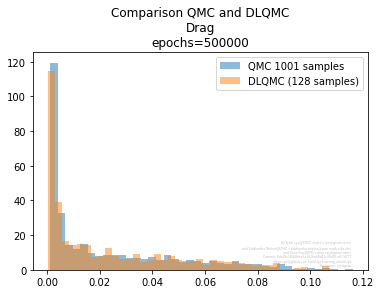

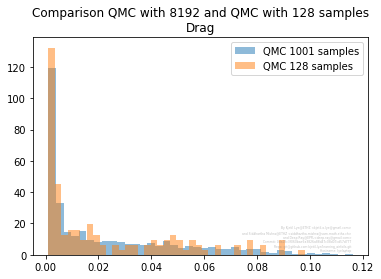

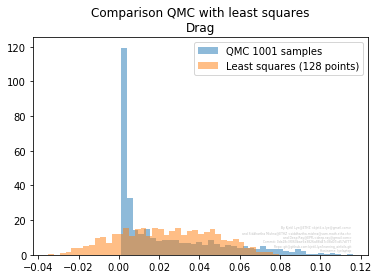

Computing large integration points


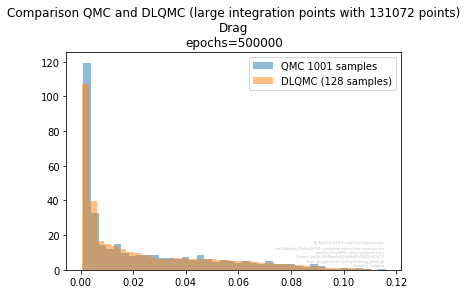

Memory usage: 985064
Memory usage: 985064


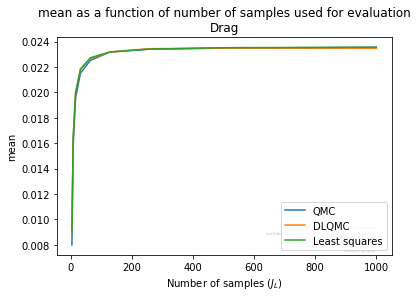

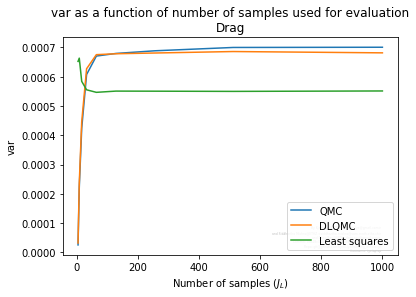

Memory usage: 985064


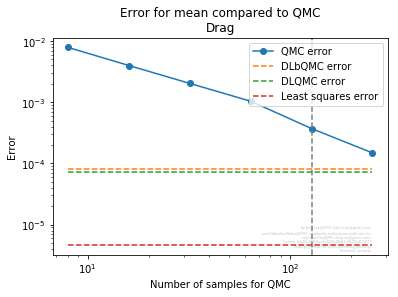

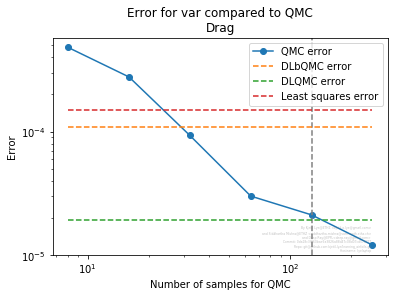

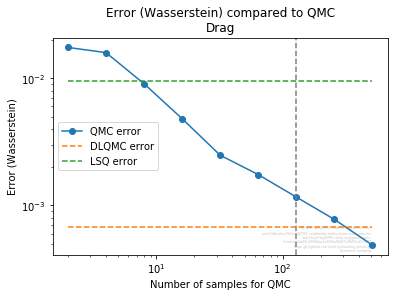

Trying with a large number of QMC samples 131072


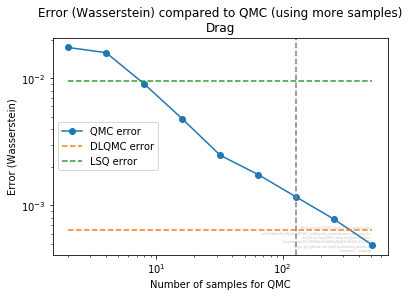



#####################################################################
#airfoil_mean_SGD_mean_squared_error_all_ts_128_bs_128_speedup_table#
#####################################################################
----  -------  -------  -----------------  ------------------  -----------------  -------------------  -----------------  ------------------
      QMC 128  QMC 128  DLQMC              DLQMC               DLbQMC             DLbQMC               Least squares      Least squares
      mean     var      mean               var                 mean               var                  mean               var
Lift  1.0      1.0      6.626256821595172  2.7338169151397613  6.945280684189319  0.07008258824411559  3.351533542911974  1.2244097653232455
Drag  1.0      1.0      5.087570229128065  1.1081759166167557  4.592802270646887  0.19407088235772157  80.23594705481086  0.1420488325277341
----  -------  -------  -----------------  ------------------  -----------------  -------------------  


Training took 1132.516593694687 seconds


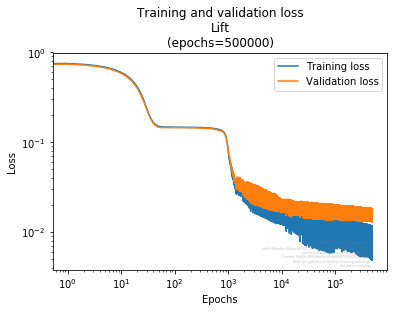


Training took 1905.2637224197388 seconds


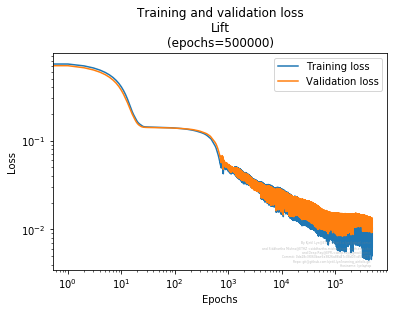


Training took 1743.9771780967712 seconds


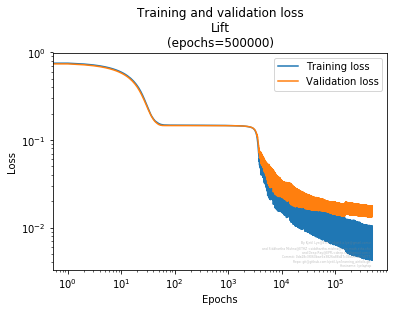


Training took 57210.84312367439 seconds


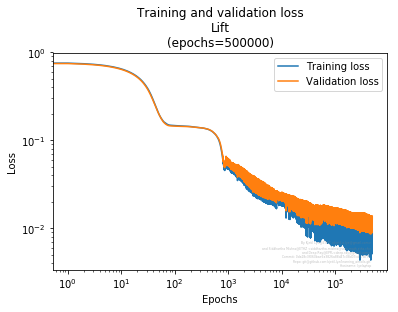


Training took 1065.1959955692291 seconds


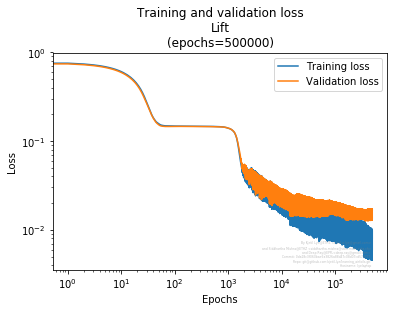


Training took 1102.172592639923 seconds


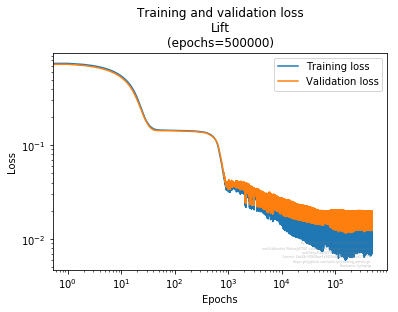

In [ ]:
force_names=['Lift', 'Drag']
batch_sizes=[train_size]
train_sizes = [16, 32, train_size]

optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}

losses = ["mean_squared_error", "mean_absolute_error"]
selections = ['mean', 'mean_train', 'mean_tail', 'prediction', 'train', 'ray_prediction']
for selection in selections:
    display(HTML("<h1>%s</h1>" % selection))
    for optimizer in optimizers.keys():
        for loss in losses:
            display(HTML("<h1>{} with {}</h1>".format(optimizer, loss)))
    
            for batch_size in batch_sizes:
                tables = Tables.make_default()
                
                for (n, f) in enumerate(force_names):
                    seed_random_number(random_seed)
                    network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                             network=airfoils_network, train_size=train_size,
                                                             validation_size=validation_size,
                                                            loss=loss, 
                                                            large_integration_points=large_qmc_points,
                                                            selection=selection, tries=10)
                    
                    output_information = OutputInformation(tables=tables, title=force_names[n],
                                                          short_title=force_names[n], enable_plotting=True)
                    showAndSave.prefix='airfoil_%s_%s_%s_%s_ts_%d_bs_%d' %(selection, optimizer, loss, f,batch_size, train_size)
                    get_network_and_postprocess(qmc_points, forces[:,n+1], network_information = network_information,
                        output_information = output_information)
                
                showAndSave.prefix='airfoil_%s_%s_%s_all_ts_%d_bs_%d' %(selection, optimizer, loss, batch_size, train_size)
                tables.write_tables()
      

# As a function of training errors

In [ ]:
force_names=['Lift', 'Drag']
epochs = 500000

optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}
loss = "mean_squared_error"
optimizer='SGD'
for n in range(len(force_names)):
    f=force_names[n]
    tables = Tables.make_default()
    def run_function(network_information, output_information):
        showAndSave.prefix='airfoil_convergence_%s_%s_%s_ts_%d_bs_%d' %(optimizer, loss, f, 
                                                                        network_information.batch_size,
                                                                        network_information.train_size)
        showAndSave.silent=True
        print_comparison_table.silent = True
        get_network_and_postprocess(qmc_points, forces[:,n+1], network_information = network_information,
            output_information = output_information)
        
        showAndSave.prefix='airfoil_convergence_result_%s_%s_%s' %(optimizer, loss, f)
        
        
    network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                     network=airfoils_network, train_size=None,
                                                     validation_size=None,
                                                    loss=loss, 
                                                    large_integration_points=None,
                                                    tries=5)
            
    output_information = OutputInformation(tables=tables, title=force_names[n],
                                          short_title=force_names[n])
    
    plot_train_size_convergence(network_information,
                               output_information, 
                               run_function,
                               qmc_points.shape[0]
                               )

In [ ]:
print(output_information.__dict__)

In [ ]:
force_names=['Lift', 'Drag']
epochs = 5

optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}
loss = "mean_squared_error"
optimizer='SGD'
selections = ['mean', 'mean_train', 'mean_tail', 'prediction']
for selection in selections:
    display(HTML("<h1>%s</h1>" % selection))
    for n in range(len(force_names)):
        f=force_names[n]
        tables = Tables.make_default()
        def run_function(network_information, output_information):
            showAndSave.prefix='airfoil_convergence_%s_%s_%s_%s_ts_%d_bs_%d' %(selection, optimizer, loss, f, 
                                                                            network_information.batch_size,
                                                                            network_information.train_size)
            showAndSave.silent=True
            print_comparison_table.silent = True
            get_network_and_postprocess(qmc_points, forces[:,n+1], network_information = network_information,
                output_information = output_information)
            
            showAndSave.prefix='airfoil_convergence_result_%s_%s_%s_%s' %(selection, optimizer, loss, f)
            
            
        network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                         network=airfoils_network, train_size=None,
                                                         validation_size=None,
                                                        loss=loss, 
                                                        selection=selection,
                                                        large_integration_points=None,
                                                        tries=10)
                
        output_information = OutputInformation(tables=tables, title=force_names[n],
                                              short_title=force_names[n])
        
        plot_train_size_convergence(network_information,
                                   output_information, 
                                   run_function,
                                   qmc_points.shape[0]
                                   )